# 06: Feedforward Network

*The fish learns to think.*

---

In notebook 05, we added positional encoding. The model now knows *what* tokens are there and *where* they are. Attention lets it gather information from context.

But attention is just *routing*. It moves information around—weighted averages of value vectors. It doesn't *transform* that information. There's no computation that says "I see an adjective followed by nothing, so I probably need a noun."

**The feedforward network (FFN)** is the "thinking" layer. It's a simple MLP applied independently to each position, *after* attention has gathered context. Its job:

- Take the information attention collected
- Process it through a nonlinear transformation
- Extract features, make inferences, compute conclusions

**The architecture:**
```
Attention output → Linear (d → 4d) → ReLU → Linear (4d → d) → FFN output
```

That's it. Expand to a wider hidden layer (room to compute), apply nonlinearity (enables complex functions), compress back down.

**The division of labor:**
- **Attention:** "Let me look around and gather relevant information"
- **FFN:** "Now let me think about what I gathered"

Both are necessary. Attention without FFN can route but not reason. FFN without attention can reason but only about the current token.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.auto import tqdm
import json
import math

# Reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'
print(f"Using device: {device}")

Using device: mps


---

## 1. Data and Tokenizer

In [2]:
from transformers import GPT2TokenizerFast

class LilTokenizer:
    """Compact tokenizer for Lil Transformy."""
    
    def __init__(self, gpt2_to_compact, compact_to_gpt2, vocab_size):
        self.gpt2_tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")
        self.gpt2_to_compact = gpt2_to_compact
        self.compact_to_gpt2 = compact_to_gpt2
        self.vocab_size = vocab_size
        self.pad_id = 0
        self.unk_id = 1
        self.eos_id = 2
    
    def encode(self, text, add_eos=True):
        gpt2_tokens = self.gpt2_tokenizer.encode(text)
        compact_tokens = [self.gpt2_to_compact.get(t, self.unk_id) for t in gpt2_tokens]
        if add_eos:
            compact_tokens.append(self.eos_id)
        return compact_tokens
    
    def decode(self, token_ids):
        gpt2_tokens = []
        for tid in token_ids:
            if tid in [self.pad_id, self.unk_id, self.eos_id]:
                continue
            if tid in self.compact_to_gpt2:
                gpt2_tokens.append(self.compact_to_gpt2[tid])
        return self.gpt2_tokenizer.decode(gpt2_tokens)
    
    def decode_single(self, token_id):
        if token_id == self.pad_id:
            return '<pad>'
        if token_id == self.unk_id:
            return '<unk>'
        if token_id == self.eos_id:
            return '<eos>'
        if token_id in self.compact_to_gpt2:
            return self.gpt2_tokenizer.decode([self.compact_to_gpt2[token_id]])
        return '<???>'
    
    def __len__(self):
        return self.vocab_size
    
    @classmethod
    def load(cls, path):
        with open(path, 'r') as f:
            config = json.load(f)
        gpt2_to_compact = {int(k): v for k, v in config['gpt2_to_compact'].items()}
        compact_to_gpt2 = {int(k): v for k, v in config['compact_to_gpt2'].items()}
        return cls(gpt2_to_compact, compact_to_gpt2, config['vocab_size'])


tokenizer = LilTokenizer.load('tokenizer/tokenizer.json')
print(f"Vocabulary size: {len(tokenizer):,}")

Vocabulary size: 4,096


In [3]:
train_data = np.load('data/train_sequences.npy')
val_data = np.load('data/val_sequences.npy')

print(f"Training sequences: {train_data.shape}")
print(f"Validation sequences: {val_data.shape}")
print(f"Context length: {train_data.shape[1]}")

Training sequences: (1851532, 256)
Validation sequences: (18616, 256)
Context length: 256


---

## 2. The Feedforward Network

The FFN is surprisingly simple. It's just a two-layer MLP with a nonlinearity in the middle:

```
FFN(x) = Linear2(ReLU(Linear1(x)))
```

The conventional "expansion factor" is 4×. If d_model is 128, the hidden dimension is 512. This gives the network room to compute intermediate features before compressing back.

**Key point:** The FFN is applied *independently* to each position. No communication between positions—that was attention's job. This is pure per-position processing.

In [4]:
class FeedForward(nn.Module):
    """
    Position-wise feedforward network.
    
    Applied independently to each position after attention.
    
    Architecture:
        x → Linear (d_model → d_ff) → ReLU → Linear (d_ff → d_model) → output
    
    The expansion to d_ff (typically 4 × d_model) gives the network
    room to compute intermediate features.
    """
    
    def __init__(self, d_model, d_ff=None):
        super().__init__()
        if d_ff is None:
            d_ff = 4 * d_model  # Standard expansion factor
        
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
    
    def forward(self, x):
        """
        Args:
            x: [batch, seq_len, d_model]
        Returns:
            [batch, seq_len, d_model]
        """
        # Expand, nonlinearity, compress
        hidden = F.relu(self.linear1(x))  # [batch, seq_len, d_ff]
        output = self.linear2(hidden)      # [batch, seq_len, d_model]
        return output

In [5]:
# Let's see what the FFN does to some random input
D_MODEL = 128
D_FF = 4 * D_MODEL  # 512

ffn = FeedForward(D_MODEL, D_FF)

# Count parameters
ffn_params = sum(p.numel() for p in ffn.parameters())
print(f"FFN parameters: {ffn_params:,}")
print(f"  linear1: {D_MODEL} × {D_FF} + {D_FF} = {D_MODEL * D_FF + D_FF:,}")
print(f"  linear2: {D_FF} × {D_MODEL} + {D_MODEL} = {D_FF * D_MODEL + D_MODEL:,}")
print()

# Test forward pass
test_input = torch.randn(2, 10, D_MODEL)  # [batch=2, seq=10, d=128]
test_output = ffn(test_input)
print(f"Input shape:  {test_input.shape}")
print(f"Output shape: {test_output.shape}")
print()
print("Same shape in and out. Each position processed independently.")

FFN parameters: 131,712
  linear1: 128 × 512 + 512 = 66,048
  linear2: 512 × 128 + 128 = 65,664

Input shape:  torch.Size([2, 10, 128])
Output shape: torch.Size([2, 10, 128])

Same shape in and out. Each position processed independently.


---

## 3. The Complete Model

Now we put it together: Embed + Position → Attention → FFN → Unembed

Note: We're still not using residual connections or layer normalization. Those come in notebook 07. For now, the FFN output goes directly to unembedding.

In [6]:
class CausalSelfAttention(nn.Module):
    """Single-head causal self-attention (same as before)."""
    
    def __init__(self, d_model, max_seq_len=256):
        super().__init__()
        self.d_model = d_model
        
        self.W_q = nn.Linear(d_model, d_model, bias=False)
        self.W_k = nn.Linear(d_model, d_model, bias=False)
        self.W_v = nn.Linear(d_model, d_model, bias=False)
        self.W_o = nn.Linear(d_model, d_model, bias=False)
        
        mask = torch.triu(torch.ones(max_seq_len, max_seq_len), diagonal=1).bool()
        self.register_buffer('mask', mask)
        self.scale = math.sqrt(d_model)
    
    def forward(self, x, return_attention=False):
        batch_size, seq_len, _ = x.shape
        
        Q = self.W_q(x)
        K = self.W_k(x)
        V = self.W_v(x)
        
        scores = (Q @ K.transpose(-2, -1)) / self.scale
        scores = scores.masked_fill(self.mask[:seq_len, :seq_len], float('-inf'))
        attn_weights = F.softmax(scores, dim=-1)
        attn_output = attn_weights @ V
        output = self.W_o(attn_output)
        
        if return_attention:
            return output, attn_weights
        return output

In [7]:
class AttentionFFNLM(nn.Module):
    """
    Language model with attention, position, AND feedforward network.
    
    Architecture:
        Token + Position → Attention → FFN → Unembed → Logits
    
    The FFN processes whatever attention gathered, extracting features
    and computing inferences that pure attention can't do.
    """
    
    def __init__(self, vocab_size, d_model, d_ff=None, max_seq_len=256):
        super().__init__()
        self.vocab_size = vocab_size
        self.d_model = d_model
        self.max_seq_len = max_seq_len
        
        if d_ff is None:
            d_ff = 4 * d_model
        self.d_ff = d_ff
        
        # Embeddings
        self.token_embedding = nn.Embedding(vocab_size, d_model)
        self.position_embedding = nn.Embedding(max_seq_len, d_model)
        
        # Attention: gather information
        self.attention = CausalSelfAttention(d_model, max_seq_len)
        
        # FFN: process information
        self.ffn = FeedForward(d_model, d_ff)
        
        # Output
        self.unembed = nn.Linear(d_model, vocab_size)
    
    def forward(self, x, return_attention=False):
        batch_size, seq_len = x.shape
        
        # Embed tokens and positions
        tok_emb = self.token_embedding(x)
        pos_emb = self.position_embedding(torch.arange(seq_len, device=x.device))
        embedded = tok_emb + pos_emb
        
        # Attention: gather context
        if return_attention:
            attended, attn_weights = self.attention(embedded, return_attention=True)
        else:
            attended = self.attention(embedded)
        
        # FFN: process context
        processed = self.ffn(attended)
        
        # Output
        logits = self.unembed(processed)
        
        if return_attention:
            return logits, attn_weights
        return logits
    
    def generate(self, prompt_tokens, max_new_tokens=50, temperature=1.0):
        """Generate tokens autoregressively."""
        self.eval()
        tokens = list(prompt_tokens)
        generated = []
        
        with torch.no_grad():
            for _ in range(max_new_tokens):
                context = tokens[-self.max_seq_len:]
                x = torch.tensor([context], device=next(self.parameters()).device)
                
                logits = self.forward(x)
                next_logits = logits[0, -1]
                
                probs = F.softmax(next_logits / temperature, dim=-1)
                next_token = torch.multinomial(probs, num_samples=1).item()
                
                generated.append(next_token)
                tokens.append(next_token)
                
                if next_token == 2:  # EOS
                    break
        
        return generated

In [8]:
# === Model Parameters ===
VOCAB_SIZE = len(tokenizer)  # 4096
D_MODEL = 128
D_FF = 4 * D_MODEL  # 512
MAX_SEQ_LEN = 256

# Create model
model = AttentionFFNLM(VOCAB_SIZE, D_MODEL, D_FF, MAX_SEQ_LEN).to(device)

# Count parameters
num_params = sum(p.numel() for p in model.parameters())
ffn_params = D_MODEL * D_FF + D_FF + D_FF * D_MODEL + D_MODEL

print(f"Total parameters: {num_params:,}")
print()
print("Breakdown:")
print(f"  Token embedding:    {VOCAB_SIZE} × {D_MODEL} = {VOCAB_SIZE * D_MODEL:,}")
print(f"  Position embedding: {MAX_SEQ_LEN} × {D_MODEL} = {MAX_SEQ_LEN * D_MODEL:,}")
print(f"  Attention:          4 × {D_MODEL} × {D_MODEL} = {4 * D_MODEL * D_MODEL:,}")
print(f"  FFN:                {D_MODEL}→{D_FF}→{D_MODEL} = {ffn_params:,}  ← NEW")
print(f"  Unembed:            {D_MODEL} × {VOCAB_SIZE} + {VOCAB_SIZE} = {D_MODEL * VOCAB_SIZE + VOCAB_SIZE:,}")
print()
print(f"Notebook 05 had {1151104:,} params.")
print(f"We added {ffn_params:,} for the FFN.")

Total parameters: 1,282,688

Breakdown:
  Token embedding:    4096 × 128 = 524,288
  Position embedding: 256 × 128 = 32,768
  Attention:          4 × 128 × 128 = 65,536
  FFN:                128→512→128 = 131,712  ← NEW
  Unembed:            128 × 4096 + 4096 = 528,384

Notebook 05 had 1,151,104 params.
We added 131,712 for the FFN.


---

## 4. Training

Same setup. One epoch. Let's see if the FFN helps.

In [9]:
# === Training Parameters ===
BATCH_SIZE = 64
LEARNING_RATE = 1e-3
NUM_EPOCHS = 1
EVAL_EVERY = 500

def make_batch(data, batch_indices):
    """Create a training batch."""
    sequences = data[batch_indices]
    x = torch.tensor(sequences[:, :-1], dtype=torch.long, device=device)
    y = torch.tensor(sequences[:, 1:], dtype=torch.long, device=device)
    return x, y

def evaluate(model, data, num_batches=50):
    """Evaluate model on validation data."""
    model.eval()
    total_loss = 0
    total_tokens = 0
    
    indices = np.random.choice(len(data), size=num_batches * BATCH_SIZE, replace=False)
    
    with torch.no_grad():
        for i in range(num_batches):
            batch_idx = indices[i * BATCH_SIZE:(i + 1) * BATCH_SIZE]
            x, y = make_batch(data, batch_idx)
            
            logits = model(x)
            logits_flat = logits.view(-1, VOCAB_SIZE)
            y_flat = y.view(-1)
            
            loss = F.cross_entropy(logits_flat, y_flat)
            
            total_loss += loss.item() * y_flat.numel()
            total_tokens += y_flat.numel()
    
    model.train()
    avg_loss = total_loss / total_tokens
    return {'loss': avg_loss, 'perplexity': math.exp(avg_loss)}


# Setup
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
steps_per_epoch = len(train_data) // BATCH_SIZE
total_steps = steps_per_epoch * NUM_EPOCHS

print(f"Steps per epoch: {steps_per_epoch:,}")
print(f"Total steps: {total_steps:,}")
print(f"Expected time: ~15 minutes")

Steps per epoch: 28,930
Total steps: 28,930
Expected time: ~15 minutes


In [10]:
# Training loop
history = {'train_loss': [], 'val_loss': [], 'val_perplexity': []}

print("Starting training...")
print("=" * 60)

step = 0
running_loss = 0

for epoch in range(NUM_EPOCHS):
    perm = np.random.permutation(len(train_data))
    epoch_pbar = tqdm(range(steps_per_epoch), desc=f"Epoch {epoch + 1}/{NUM_EPOCHS}")
    
    for batch_num in epoch_pbar:
        batch_idx = perm[batch_num * BATCH_SIZE:(batch_num + 1) * BATCH_SIZE]
        x, y = make_batch(train_data, batch_idx)
        
        optimizer.zero_grad()
        logits = model(x)
        
        logits_flat = logits.view(-1, VOCAB_SIZE)
        y_flat = y.view(-1)
        loss = F.cross_entropy(logits_flat, y_flat)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        step += 1
        
        if step % EVAL_EVERY == 0:
            avg_train_loss = running_loss / EVAL_EVERY
            val_metrics = evaluate(model, val_data)
            
            history['train_loss'].append(avg_train_loss)
            history['val_loss'].append(val_metrics['loss'])
            history['val_perplexity'].append(val_metrics['perplexity'])
            
            epoch_pbar.set_postfix({
                'loss': f"{avg_train_loss:.3f}",
                'val_loss': f"{val_metrics['loss']:.3f}",
                'ppl': f"{val_metrics['perplexity']:.1f}"
            })
            
            running_loss = 0

print("\nTraining complete!")

Starting training...


Epoch 1/1:   0%|          | 0/28930 [00:00<?, ?it/s]


Training complete!


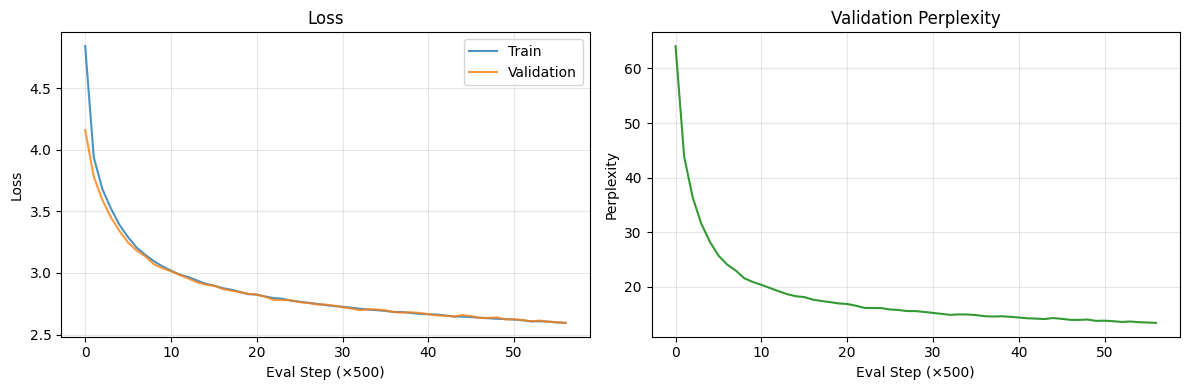


Final validation loss: 2.595
Final validation perplexity: 13.4


In [11]:
# Plot training curves
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(history['train_loss'], label='Train', alpha=0.8)
axes[0].plot(history['val_loss'], label='Validation', alpha=0.8)
axes[0].set_xlabel(f'Eval Step (×{EVAL_EVERY})')
axes[0].set_ylabel('Loss')
axes[0].set_title('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history['val_perplexity'], color='green', alpha=0.8)
axes[1].set_xlabel(f'Eval Step (×{EVAL_EVERY})')
axes[1].set_ylabel('Perplexity')
axes[1].set_title('Validation Perplexity')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('06_training_curves.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

print(f"\nFinal validation loss: {history['val_loss'][-1]:.3f}")
print(f"Final validation perplexity: {history['val_perplexity'][-1]:.1f}")

---

## 5. Comparison: Did the FFN Help?

In [12]:
# Load previous results
checkpoint_03 = torch.load('03_bigram.pt', map_location='cpu', weights_only=False)
checkpoint_04 = torch.load('04_attention.pt', map_location='cpu', weights_only=False)
checkpoint_05 = torch.load('05_positional.pt', map_location='cpu', weights_only=False)

print("=" * 65)
print("COMPARISON: How Much Did the FFN Help?")
print("=" * 65)
print()
print(f"{'Model':<30} {'Params':<12} {'Epochs':<8} {'Val PPL':<10}")
print("-" * 65)
print(f"{'03: Bigram':<30} {'1,052,672':<12} {'1':<8} {checkpoint_03['history']['val_perplexity'][-1]:<10.1f}")
print(f"{'04: + Attention':<30} {'1,118,208':<12} {'3':<8} {checkpoint_04['history']['val_perplexity'][-1]:<10.1f}")
print(f"{'05: + Position':<30} {'1,151,104':<12} {'1':<8} {checkpoint_05['history']['val_perplexity'][-1]:<10.1f}")
print(f"{'06: + FFN (this)':<30} {f'{num_params:,}':<12} {'1':<8} {history['val_perplexity'][-1]:<10.1f}")
print()
print("Question: Does the FFN help at 1 epoch, or does the extra capacity")
print("need more time to learn?")

COMPARISON: How Much Did the FFN Help?

Model                          Params       Epochs   Val PPL   
-----------------------------------------------------------------
03: Bigram                     1,052,672    1        35.8      
04: + Attention                1,118,208    3        25.0      
05: + Position                 1,151,104    1        17.7      
06: + FFN (this)               1,282,688    1        13.4      

Question: Does the FFN help at 1 epoch, or does the extra capacity
need more time to learn?


---

## 6. Generation

In [13]:
def generate_and_print(prompt, max_tokens=50, temperature=1.0):
    """Generate from a prompt and print results."""
    prompt_tokens = tokenizer.encode(prompt, add_eos=False)
    generated_tokens = model.generate(prompt_tokens, max_new_tokens=max_tokens, temperature=temperature)
    generated_text = tokenizer.decode(generated_tokens)
    
    print(f"Prompt: {prompt}")
    print(f"Generated: {generated_text}")
    print()


print("=" * 60)
print("GENERATION TEST")
print("=" * 60)
print()

test_prompts = [
    "Once upon a time",
    "The little girl",
    "Once upon a time there was a little girl named Lily. She",
    "The boy was sad because his toy was broken. His mom said",
]

for prompt in test_prompts:
    generate_and_print(prompt, max_tokens=40)

GENERATION TEST

Prompt: Once upon a time
Generated:  there were two young friends - Molly and her dad: three.

One day, Sarah and Bill were getting very tired and Lucy was. She was very excited! 

The

Prompt: The little girl
Generated:  said, "We are lucky to see!"

The little girl replied, "Goodbye, you saved me from cover your messy piles."

They looked back. The little girl was curious

Prompt: Once upon a time there was a little girl named Lily. She
Generated:  loved to eat animals and play with her toys sometimes she felt sad and lonely. 

One day she went outside to play in the park with her friends. While she was playing in the muddy

Prompt: The boy was sad because his toy was broken. His mom said
Generated: , "What's the puppy was crying my name?"

"My name is,. There is other bookscase. Can you teach me more and write?"

"Maybe the



---

## 7. What Is the FFN Learning?

One way to peek inside: look at which hidden units activate for different inputs.

The FFN has 512 hidden units. After ReLU, each unit is either "on" (positive) or "off" (zero). We can see which units fire for different tokens.

In [14]:
def get_ffn_activations(text):
    """
    Get FFN hidden activations for each position in the text.
    """
    tokens = tokenizer.encode(text, add_eos=False)
    token_strs = [tokenizer.decode_single(t) for t in tokens]
    
    model.eval()
    activations = []
    
    def hook(module, input, output):
        # Capture the hidden activations (after ReLU)
        activations.append(output.detach().cpu())
    
    # Register hook on the ReLU (which is inside linear1 -> relu -> linear2)
    # We'll manually compute to get the hidden layer
    with torch.no_grad():
        x = torch.tensor([tokens], device=device)
        
        # Forward through embeddings and attention
        tok_emb = model.token_embedding(x)
        pos_emb = model.position_embedding(torch.arange(len(tokens), device=device))
        embedded = tok_emb + pos_emb
        attended = model.attention(embedded)
        
        # Get FFN hidden activations
        hidden = F.relu(model.ffn.linear1(attended))  # [1, seq_len, d_ff]
    
    return hidden[0].cpu().numpy(), token_strs  # [seq_len, d_ff]


# Get activations for a sample sentence
activations, tokens = get_ffn_activations("Once upon a time there was a little girl")

print(f"Activations shape: {activations.shape}")
print(f"  - {len(tokens)} positions")
print(f"  - {activations.shape[1]} hidden units")
print()

# How many units are active (>0) at each position?
active_counts = (activations > 0).sum(axis=1)
print("Active units per position:")
for tok, count in zip(tokens, active_counts):
    print(f"  {tok:>12}: {count} / {activations.shape[1]} units active")

Activations shape: (9, 512)
  - 9 positions
  - 512 hidden units

Active units per position:
          Once: 181 / 512 units active
          upon: 248 / 512 units active
             a: 166 / 512 units active
          time: 175 / 512 units active
         there: 203 / 512 units active
           was: 193 / 512 units active
             a: 157 / 512 units active
        little: 164 / 512 units active
          girl: 165 / 512 units active


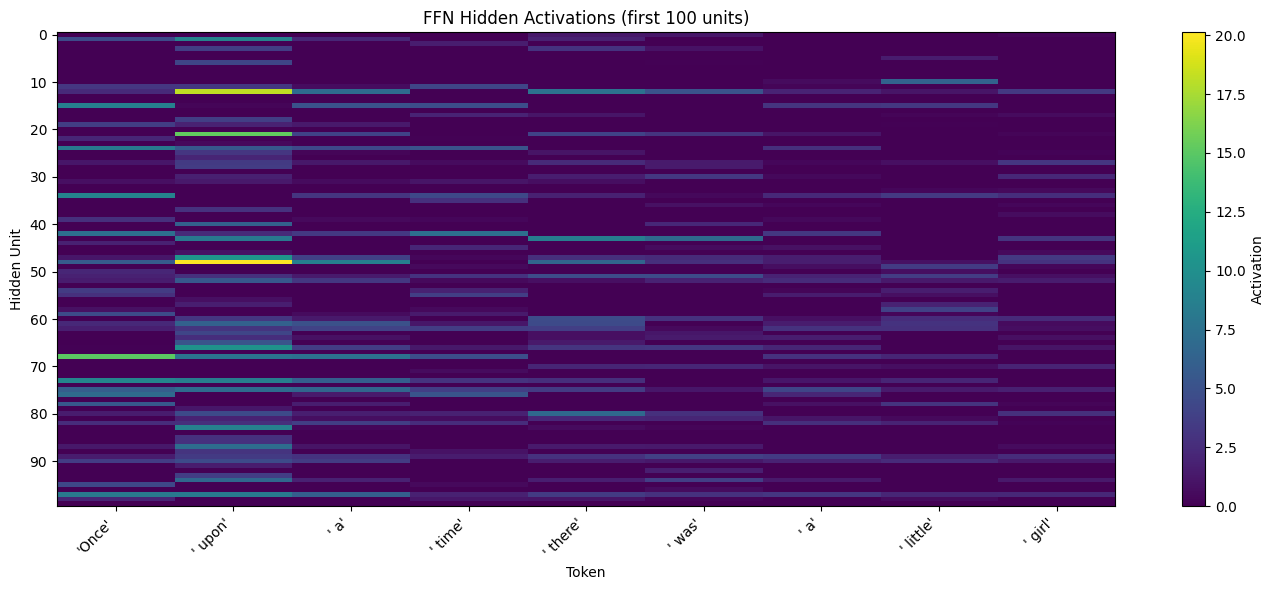

Each column is a token. Each row is a hidden unit.
Bright = high activation. Dark = zero (ReLU killed it).
Different tokens activate different patterns of units.


In [15]:
# Visualize activation patterns
fig, ax = plt.subplots(figsize=(14, 6))

# Show first 100 hidden units for clarity
im = ax.imshow(activations[:, :100].T, aspect='auto', cmap='viridis')

ax.set_yticks(range(0, 100, 10))
ax.set_xticks(range(len(tokens)))
ax.set_xticklabels([repr(t) for t in tokens], rotation=45, ha='right')

ax.set_xlabel('Token')
ax.set_ylabel('Hidden Unit')
ax.set_title('FFN Hidden Activations (first 100 units)')

plt.colorbar(im, ax=ax, label='Activation')
plt.tight_layout()
plt.savefig('06_ffn_activations.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

print("Each column is a token. Each row is a hidden unit.")
print("Bright = high activation. Dark = zero (ReLU killed it).")
print("Different tokens activate different patterns of units.")

---

## Summary

### What We Added

**Feedforward network:** A two-layer MLP applied independently to each position after attention.

```python
hidden = F.relu(linear1(x))  # [batch, seq, d_model] → [batch, seq, d_ff]
output = linear2(hidden)      # [batch, seq, d_ff] → [batch, seq, d_model]
```

### The Division of Labor

- **Attention:** Routes information between positions ("let me gather context")
- **FFN:** Processes information at each position ("let me think about it")

### Why This Helps

Attention is linear in the values—weighted averages can't compute nonlinear functions. The FFN adds nonlinearity (ReLU) and capacity (wider hidden layer), enabling computations like "I see an adjective, I need a noun" that pure attention can't express.

### What's Still Missing

- **Residual connections:** Information flows around layers, not just through them
- **Layer normalization:** Stabilizes training
- **Multiple heads:** Parallel attention patterns
- **Stacked layers:** Deeper processing

### The Lesson

Attention gathers. FFN thinks. You need both.

In [16]:
# Save model checkpoint
checkpoint = {
    'model_state_dict': model.state_dict(),
    'vocab_size': VOCAB_SIZE,
    'd_model': D_MODEL,
    'd_ff': D_FF,
    'max_seq_len': MAX_SEQ_LEN,
    'history': history,
}

torch.save(checkpoint, '06_ffn.pt')
print("Model saved to 06_ffn.pt")

Model saved to 06_ffn.pt


In [17]:
print("=" * 60)
print("NOTEBOOK 06 COMPLETE")
print("=" * 60)
print(f"\nArchitecture: Token + Position → Attention → FFN → Unembed")
print(f"Parameters: {num_params:,}")
print(f"Training: {NUM_EPOCHS} epoch")
print(f"Final perplexity: {history['val_perplexity'][-1]:.1f}")
print()
print("The fish can think.")
print("Next: Residual connections so information can flow around layers.")

NOTEBOOK 06 COMPLETE

Architecture: Token + Position → Attention → FFN → Unembed
Parameters: 1,282,688
Training: 1 epoch
Final perplexity: 13.4

The fish can think.
Next: Residual connections so information can flow around layers.
